In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df=pd.read_csv(r"C:\Users\NIHAL_MIRAJ\Desktop\exchange_rate.csv")

In [3]:
df.head()

,date,Ex_rate
0,01-01-1990 00:00,0.7855
1,02-01-1990 00:00,0.7818
2,03-01-1990 00:00,0.7867
3,04-01-1990 00:00,0.7860
4,05-01-1990 00:00,0.7849


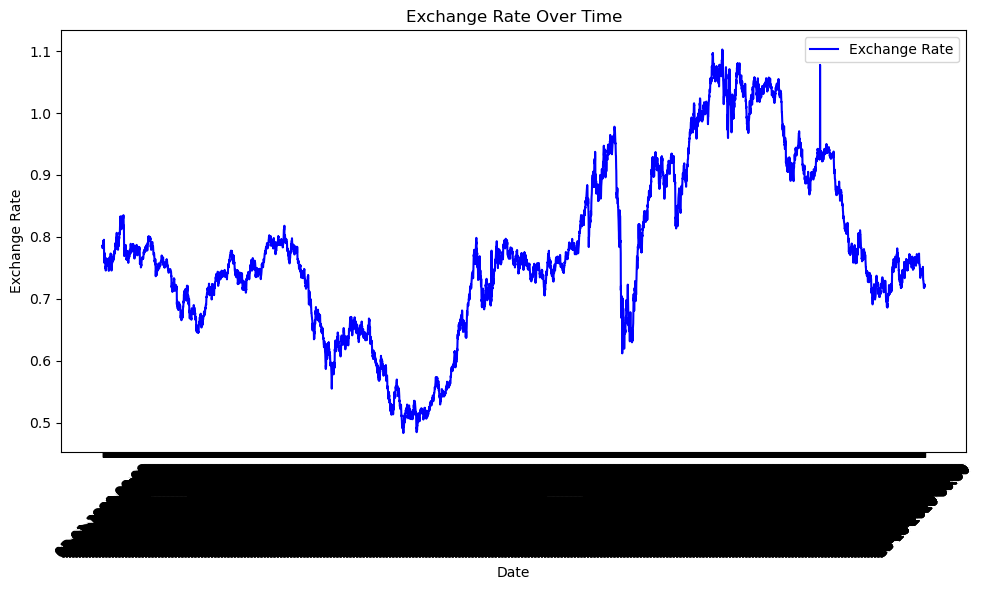

In [4]:
plt.figure(figsize=(10, 6))
plt.plot(df['date'], df['Ex_rate'], label='Exchange Rate', color='blue')
plt.title('Exchange Rate Over Time')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [5]:
df.isnull().sum()

date       0
Ex_rate    0
dtype: int64

In [6]:
df = df[df['Ex_rate'] > 0]

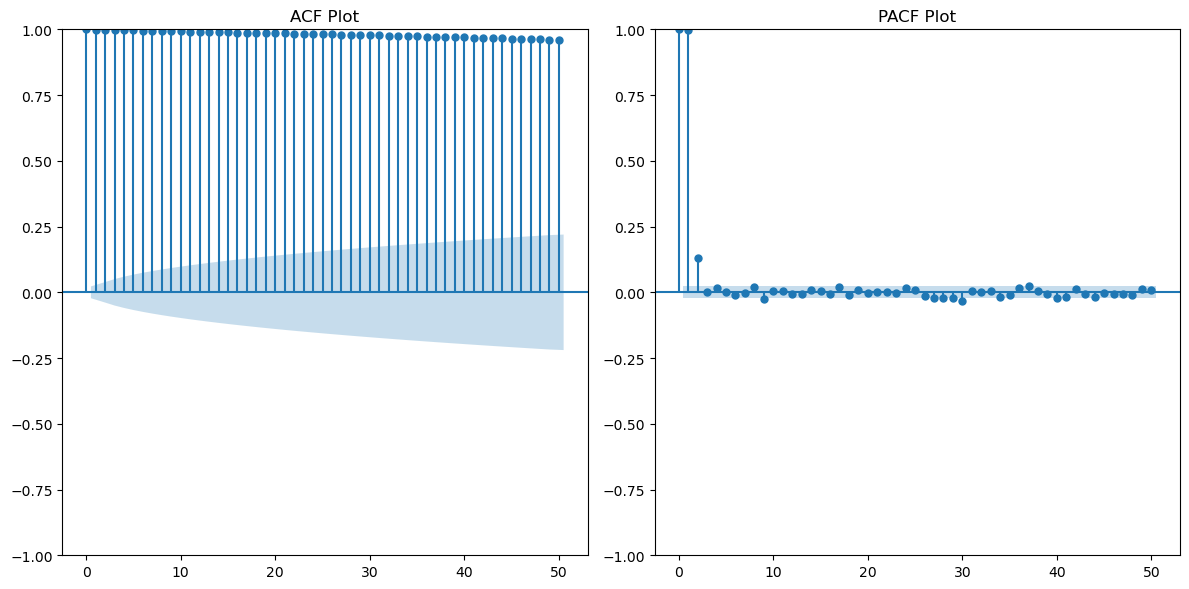

In [7]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot ACF and PACF for the 'Ex_rate' time series
plt.figure(figsize=(12, 6))

# ACF Plot
plt.subplot(121)
plot_acf(df['Ex_rate'], lags=50, ax=plt.gca(), title="ACF Plot")

# PACF Plot
plt.subplot(122)
plot_pacf(df['Ex_rate'], lags=50, ax=plt.gca(), title="PACF Plot")

plt.tight_layout()
plt.show()


In [8]:
from statsmodels.tsa.arima.model import ARIMA

# Fit the ARIMA model
model = ARIMA(df['Ex_rate'], order=(1, 2, 1))
fitted_model = model.fit()

# Display the model summary
print(fitted_model.summary())


                               SARIMAX Results                                
Dep. Variable:                Ex_rate   No. Observations:                 7588
Model:                 ARIMA(1, 2, 1)   Log Likelihood               28041.525
Date:                Thu, 26 Dec 2024   AIC                         -56077.050
Time:                        15:24:29   BIC                         -56056.248
Sample:                             0   HQIC                        -56069.911
                               - 7588                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1330      0.002    -60.300      0.000      -0.137      -0.129
ma.L1         -0.9996      0.009   -112.593      0.000      -1.017      -0.982
sigma2      3.599e-05   3.02e-07    119.289      0.0

C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


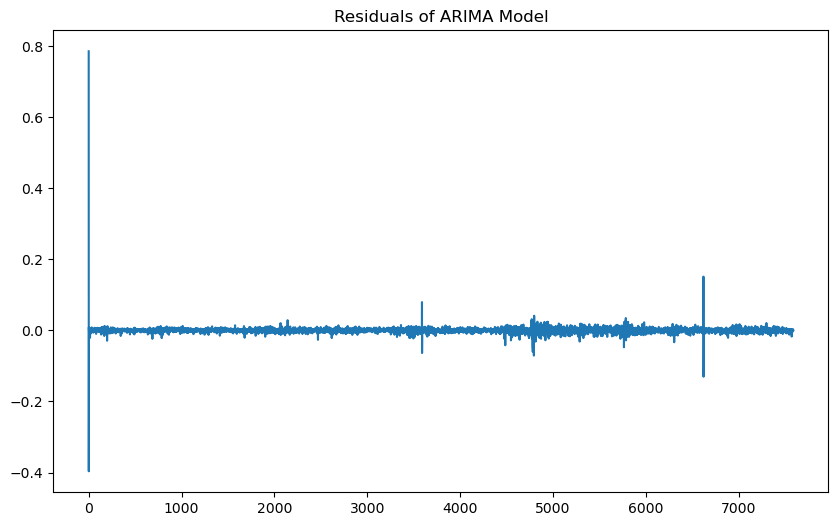

In [9]:
residuals = fitted_model.resid
plt.figure(figsize=(10, 6))
plt.plot(residuals)
plt.title('Residuals of ARIMA Model')
plt.show()

In [10]:
# Perform a Ljung-Box test to check for autocorrelation in the residuals
from statsmodels.stats.diagnostic import acorr_ljungbox
lb_test = acorr_ljungbox(residuals, lags=[10], return_df=True)
print(lb_test)

       lb_stat      lb_pvalue
10  687.072583  3.739684e-141


In [11]:
# Forecasting out of sample (e.g., next 10 periods)
forecast_steps = 10
forecast = fitted_model.forecast(steps=forecast_steps)

In [12]:
df['date'] = pd.to_datetime(df['date'], format='%d-%m-%Y %H:%M')

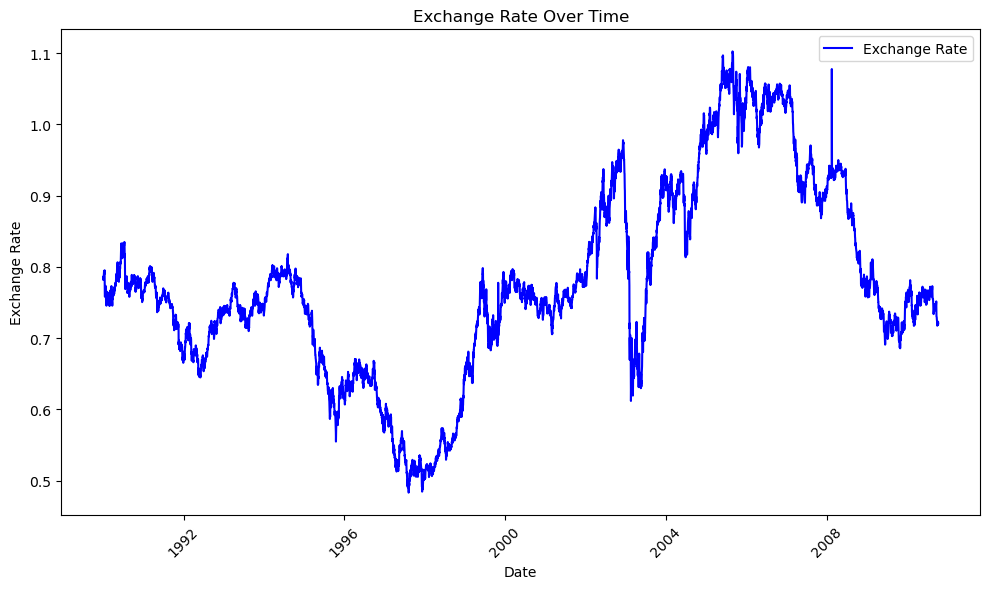

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(df['date'], df['Ex_rate'], label='Exchange Rate', color='blue')
plt.title('Exchange Rate Over Time')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [25]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

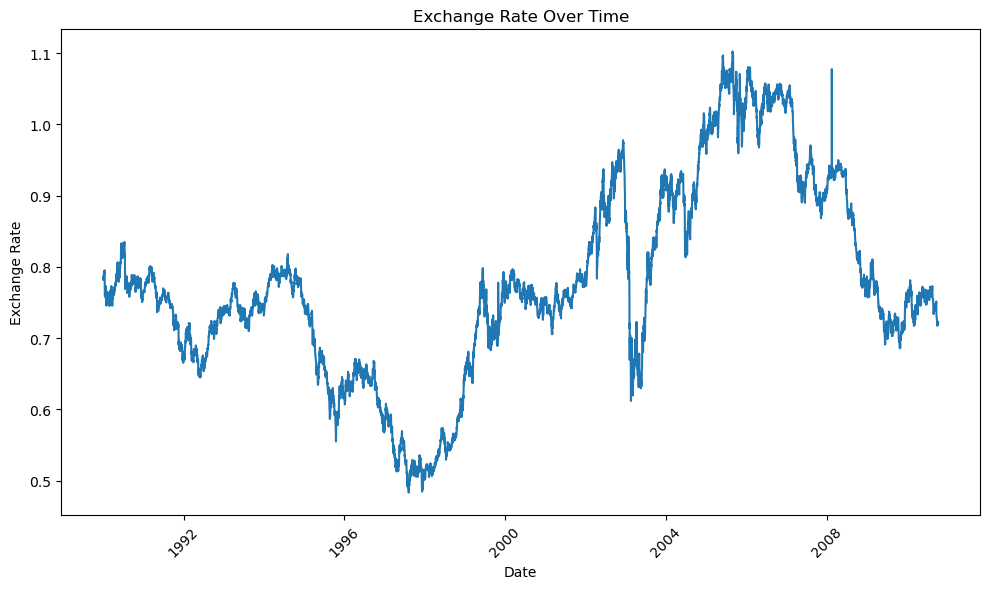

In [26]:
plt.figure(figsize=(10, 6))
plt.plot(df['date'], df['Ex_rate'], label='Exchange Rate')
plt.title('Exchange Rate Over Time')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [27]:
model = ExponentialSmoothing(df['Ex_rate'], trend='add', seasonal='add', seasonal_periods=12)

In [30]:
best_aic = float('inf')
best_params = None
param_grid = [
    ('add', 'add', 12),
    ('add', 'mul', 12),
    ('mul', 'add', 12),
    ('add', 'add', 6),
    ('add', 'mul', 6)
]
for trend, seasonal, periods in param_grid:
    model = ExponentialSmoothing(df['Ex_rate'], trend=trend, seasonal=seasonal, seasonal_periods=periods)
    fitted_model = model.fit()
    if fitted_model.aic < best_aic:
        best_aic = fitted_model.aic
        best_params = (trend, seasonal, periods)

print(f"Best Parameters: Trend={best_params[0]}, Seasonal={best_params[1]}, Seasonal Periods={best_params[2]}")

C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


Best Parameters: Trend=add, Seasonal=add, Seasonal Periods=6


In [31]:
best_model = ExponentialSmoothing(df['Ex_rate'], trend=best_params[0], seasonal=best_params[1], seasonal_periods=best_params[2])
fitted_model = best_model.fit()

In [32]:
forecast_steps = 10
forecast = fitted_model.forecast(steps=forecast_steps)

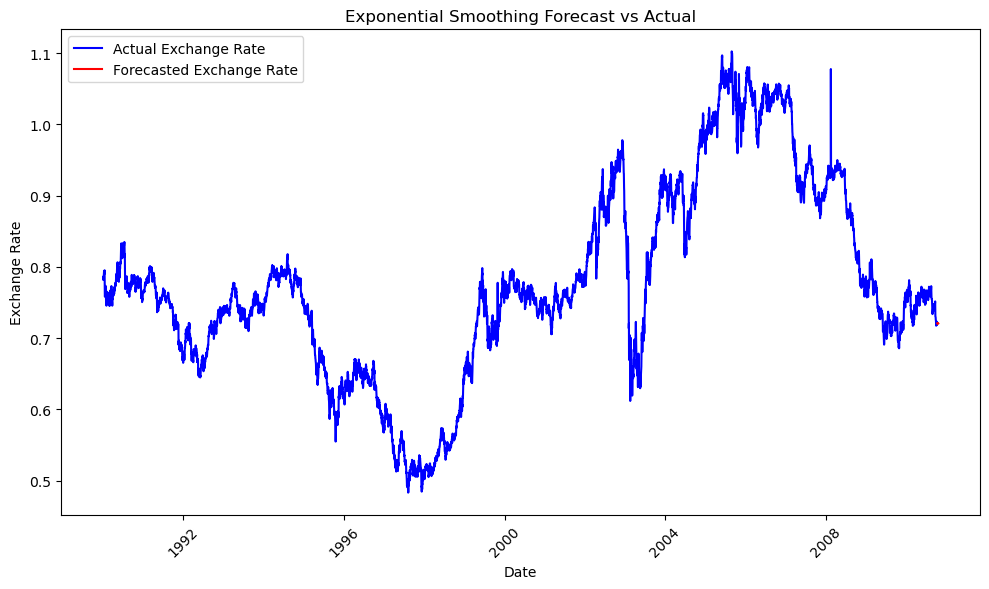

In [33]:
plt.figure(figsize=(10, 6))
plt.plot(df['date'], df['Ex_rate'], label='Actual Exchange Rate', color='blue')
plt.plot(pd.date_range(df['date'].iloc[-1], periods=forecast_steps+1, freq='D')[1:], forecast, label='Forecasted Exchange Rate', color='red')
plt.title('Exponential Smoothing Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [18]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [19]:
# Assuming you have the forecasts from both ARIMA and Exponential Smoothing models
# Actual values for comparison (e.g., last 10 data points in the original dataset)
actual_values = df['Ex_rate'].iloc[-10:].values

In [20]:
arima_forecast = fitted_model.forecast(steps=10)
exponential_forecast = fitted_model.forecast(steps=10)

In [22]:
# Compute MAE, RMSE, and MAPE for ARIMA model
mae_arima = mean_absolute_error(actual_values, arima_forecast)
rmse_arima = np.sqrt(mean_squared_error(actual_values, arima_forecast))
mape_arima = np.mean(np.abs((actual_values - arima_forecast) / actual_values)) * 100

In [23]:
# Compute MAE, RMSE, and MAPE for Exponential Smoothing model
mae_exponential = mean_absolute_error(actual_values, exponential_forecast)
rmse_exponential = np.sqrt(mean_squared_error(actual_values, exponential_forecast))
mape_exponential = np.mean(np.abs((actual_values - exponential_forecast) / actual_values)) * 100


In [24]:
print(f"ARIMA Model Error Metrics:")
print(f"MAE: {mae_arima}")
print(f"RMSE: {rmse_arima}")
print(f"MAPE: {mape_arima}%\n")

print(f"Exponential Smoothing Model Error Metrics:")
print(f"MAE: {mae_exponential}")
print(f"RMSE: {rmse_exponential}")
print(f"MAPE: {mape_exponential}%")

ARIMA Model Error Metrics:
MAE: 0.0017266895639504898
RMSE: 0.0019195949853200642
MAPE: 0.23976545386633932%

Exponential Smoothing Model Error Metrics:
MAE: 0.0017266895639504898
RMSE: 0.0019195949853200642
MAPE: 0.23976545386633932%
